In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce
from utils import preprocess
import tsfresh

%reload_ext autoreload
%autoreload 2

# Load Data

In [2]:
raw_data_dict = {name[:-16]: pd.read_csv(f'data/{name}', index_col=0, parse_dates=True) for name in os.listdir('data') if name.endswith('(2017-2023).csv')}
dataset = reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True), map(lambda x: x[1].add_prefix(f'{x[0]} '), raw_data_dict.items())).dropna()
dataset

,Microsoft Open,Microsoft High,Microsoft Low,Microsoft Close,Microsoft Adj Close,Microsoft Volume,10year treasury yield Open,10year treasury yield High,10year treasury yield Low,10year treasury yield Close,...,Amazon Low,Amazon Close,Amazon Adj Close,Amazon Volume,Google Open,Google High,Google Low,Google Close,Google Adj Close,Google Volume
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-31,73.300003,73.440002,72.410004,72.699997,67.442795,23600100,2.294,2.305,2.291,2.292,...,49.351002,49.389000,49.389000,147042000,47.094501,47.179501,46.301998,46.525002,46.525002,39402000
2017-08-01,73.099998,73.419998,72.489998,72.580002,67.331490,22132300,2.305,2.321,2.251,2.251,...,49.578999,49.809502,49.809502,91452000,46.618999,46.872349,46.463001,46.541500,46.541500,25554000
2017-08-02,72.550003,72.559998,71.440002,72.260002,67.034630,26499200,2.271,2.284,2.243,2.262,...,49.086498,49.794498,49.794498,81400000,46.430500,46.630001,45.834000,46.519501,46.519501,36488000
2017-08-03,72.190002,72.440002,71.849998,72.150002,66.932602,18214400,2.243,2.251,2.228,2.228,...,49.229500,49.346001,49.346001,65116000,46.516998,46.612000,46.112000,46.182499,46.182499,24050000
2017-08-04,72.400002,73.040001,72.239998,72.680000,67.424248,22579000,2.232,2.291,2.230,2.267,...,49.099998,49.379002,49.379002,54606000,46.337502,46.515350,46.151501,46.397999,46.397999,21646000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25,347.109985,351.890015,345.070007,350.980011,350.980011,41637700,3.892,3.922,3.885,3.912,...,128.529999,129.130005,129.130005,39236700,121.879997,123.690002,121.529999,122.790001,122.790001,31820800
2023-07-26,341.440002,344.670013,333.109985,337.769989,337.769989,58383700,3.885,3.904,3.849,3.851,...,126.110001,128.149994,128.149994,53910100,130.360001,131.369995,128.710007,129.660004,129.660004,46216900
2023-07-27,340.480011,341.329987,329.049988,330.720001,330.720001,39635300,3.863,4.022,3.853,4.012,...,127.790001,128.250000,128.250000,52610700,131.800003,133.600006,129.179993,129.869995,129.869995,35931600


# tsfresh

In [4]:
def extract_features(df):
    extracted_features = tsfresh.extract_features(df, column_id="Apple Close")
    return extracted_features

extracted_features = extract_features(dataset)
extracted_features

Feature Extraction:   0%|          | 0/634 [00:00<?, ?it/s]

# Add News

In [104]:
# news = pd.concat((
#     pd.read_csv('data/News1year.csv', encoding='latin1', header=None, names=['Date','Title','Evaluation', 'Prob'], index_col=0),
#     pd.read_csv('data/News5years.csv', encoding='latin1', header=None, names=['Date','Title','Evaluation', 'Prob'], index_col=0),
# )).sort_index()
# news.index = pd.to_datetime(news.index.map(lambda x: x[:10]))
news = pd.read_csv('data/Apple News.csv', index_col=0, parse_dates=True)
news['Evaluation'] = news['Evaluation'].map({'negative': 0, 'neutral': 0.5, 'positive': 1})
news_evaluation = pd.Series({date: d['Evaluation'].dot(d['Prob']) / d['Prob'].sum() for date, d in news.groupby('Date')}).rename('News')

dataset = pd.merge(
    dataset,
    news_evaluation.to_frame().add_prefix("Apple "),
    left_index=True,
    right_index=True,
).dropna()
dataset = dataset.loc[dataset.index.duplicated(keep="first") == False]

In [105]:
target = 'Amazon'

# Add Technical Indicators

In [106]:
dataset = pd.merge(
    dataset, 
    preprocess.get_technical_indicators(dataset[f'{target} Close']).add_prefix(f'{target} '), 
    left_index=True, 
    right_index=True,
    how='left'
)

assert len(dataset) == len(set(dataset.index))


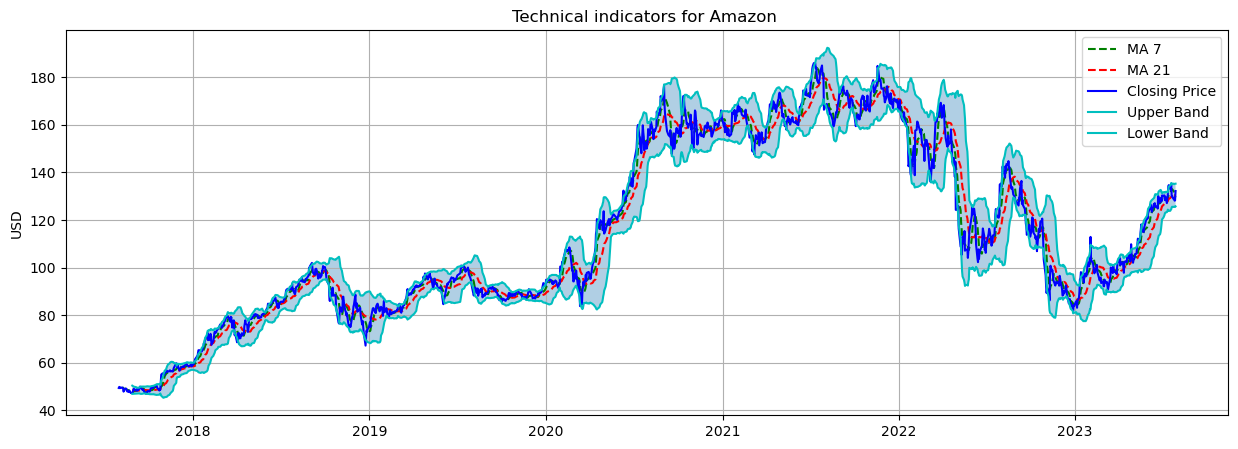

In [107]:
def plot_technical_indicators(dataset, prefix=''):
    plt.figure(figsize=(15, 5))    
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.plot(dataset[prefix+'ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset[prefix+'ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset[prefix+'Close'],label='Closing Price', color='b')
    plt.plot(dataset[prefix+'upper_band'],label='Upper Band', color='c')
    plt.plot(dataset[prefix+'lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset[prefix+'lower_band'], dataset[prefix+'upper_band'], alpha=0.35)
    plt.title(f'Technical indicators for {prefix}')
    plt.ylabel('USD')
    plt.grid()
    plt.legend()

plot_technical_indicators(dataset, f'{target} ')
plt.savefig(f'images/{target} technical indicators.png', bbox_inches='tight', dpi=300)

# Fourier transforms

## IFFT

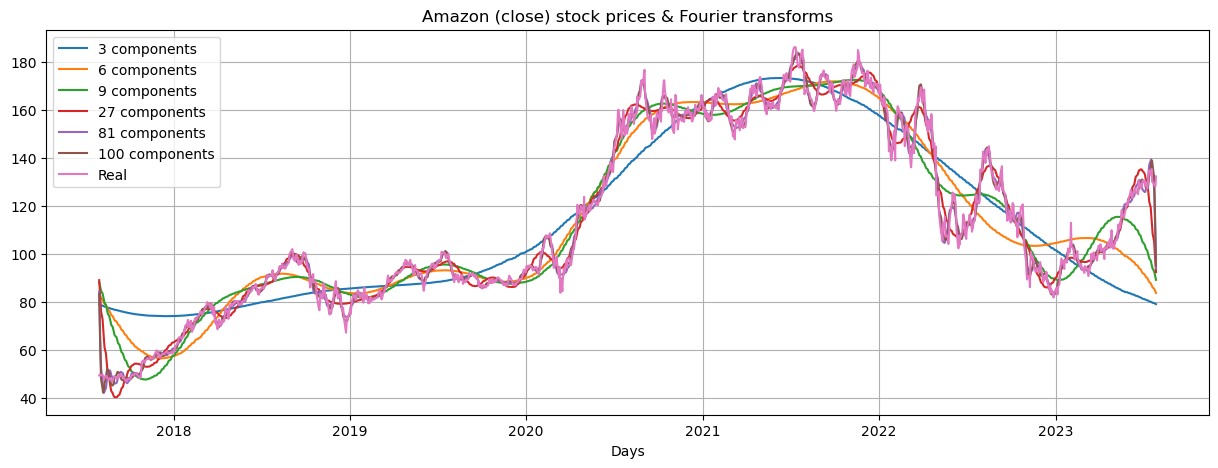

In [108]:
plt.figure(figsize=(15, 5))

data = dataset[f'{target} Close']
fourier_components = preprocess.get_fourier_components(data, [3, 6, 9, 27, 81, 100])

dataset = pd.merge(
    dataset,
    fourier_components,
    left_index=True,
    right_index=True
)
assert len(dataset) == len(set(dataset.index))


for component in fourier_components:
    plt.plot(fourier_components[component], label=component[3:])


    
plt.plot(data,  label='Real')
plt.xlabel('Days')
plt.title(f'{target} (close) stock prices & Fourier transforms')
plt.legend()
plt.grid()
plt.savefig(f'images/{target} (close) stock prices & Fourier transforms.png', dpi=300, bbox_inches='tight')

## STFT

In [109]:
dataset = pd.merge(
    dataset,
    preprocess.get_stft_features(dataset[f'{target} Close']).add_prefix(f'{target} '),
    left_index=True, 
    right_index=True
)

assert len(dataset) == len(set(dataset.index))

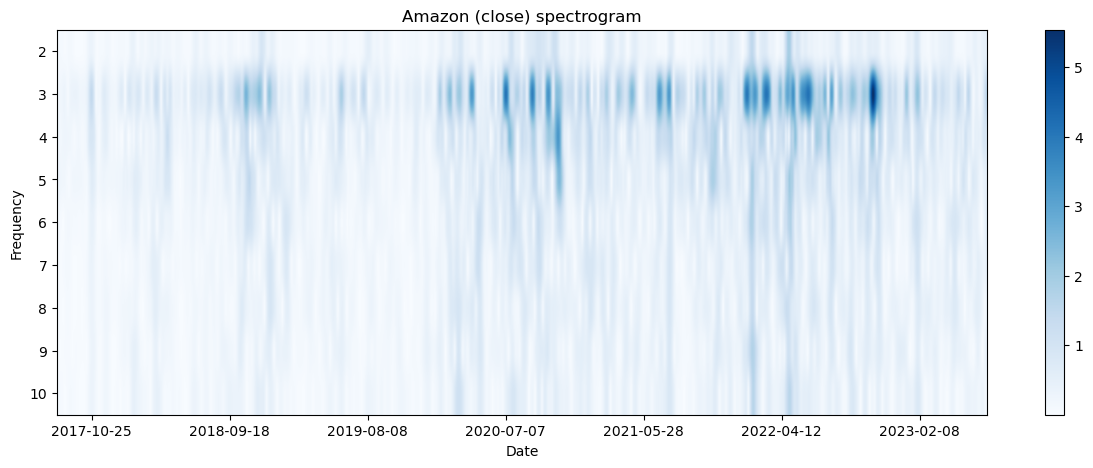

In [110]:
plt.figure(figsize=(15, 5))
plt.imshow(
    dataset[sorted(filter(lambda s: s.split()[-1].startswith('STFT'), dataset.columns))[2:]].T,
    aspect='auto',
    cmap='Blues'
)
plt.colorbar()
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(range(50, len(dataset), 200), [d.date() for d in dataset.index[50::200]], rotation=0)
plt.yticks(range(0, 9), range(2, 11))
plt.title(f'{target} (close) spectrogram')
plt.savefig(f'images/{target} spectrogram.png', dpi=300, bbox_inches='tight')

## DWT

In [111]:
dataset = pd.merge(
    dataset, 
    preprocess.get_wavelet_features(dataset[f'{target} Close']).add_prefix(f'{target} '),
    left_index=True, 
    right_index=True
)

assert len(dataset) == len(set(dataset.index))


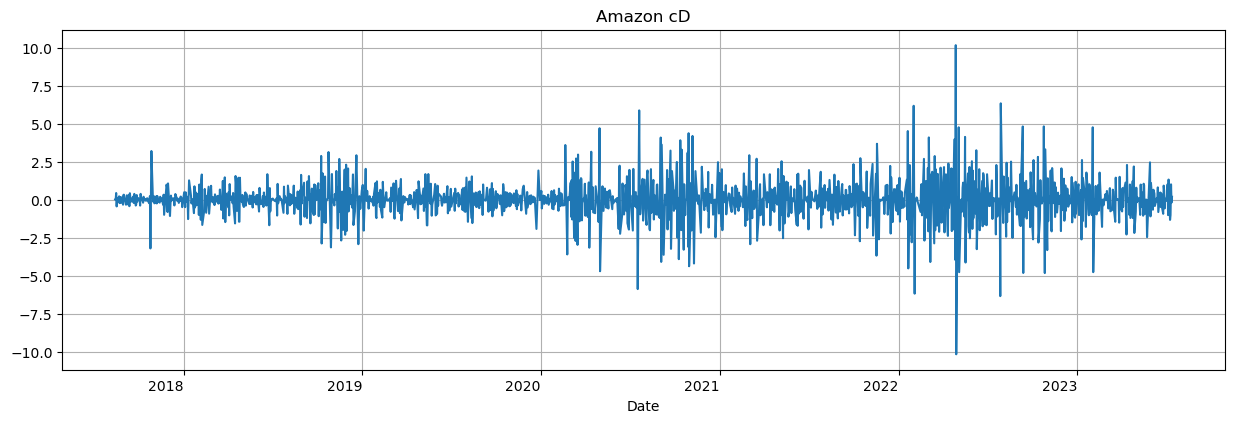

In [112]:
plt.figure(figsize=(15, 5))
dataset[f'{target} cD'].plot(rot=0)
plt.title(f'{target} cD')
plt.xlabel('Date')
plt.grid()
plt.savefig(f'images/{target} cD.png', bbox_inches='tight', dpi=300)

# Save 

In [113]:
dataset.dropna(inplace=True)
dataset.drop_duplicates(inplace=True)
dataset.sort_index(axis=1, inplace=True)
dataset.to_pickle('data/processed_dataset.pkl')

# News

In [114]:
# dataset['Apple News'].plot(
#     figsize=(15, 5), 
#     title='Evalution of news per day', 
#     grid=True, 
#     color='#096A62', 
#     alpha=0.9,
# )
# plt.savefig('images/evalution_per_day.png', bbox_inches='tight', dpi=300)

In [115]:
# dataset['Apple News'].plot(
#     figsize=(15, 5), 
#     title='Number of news per day', 
#     grid=True, 
#     color='#096A62', 
#     alpha=0.9,
# )
# plt.savefig('images/news_per_day.png', bbox_inches='tight', dpi=300)